In [1]:
import tensorflow as tf

import keras

import numpy as np

Using TensorFlow backend.


In [2]:
from keras.layers import Input, LSTM, RepeatVector, Dense, Embedding, Activation, Masking, SimpleRNN
from keras.layers.wrappers import TimeDistributed
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [3]:
from functools import reduce

In [4]:
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
import tqdm 

In [5]:
from IPython import display

## Data

In [6]:
X = np.load("../data/ES/es3_graph.npy")[:34,:34]
print(X.shape)

(34, 34)


In [7]:
VOC_SIZE = 34
mask_val = 0
emb_size = 20
LSTM_INTERNAL_DIM = 30

In [8]:
CHAIN_LEN = 20

In [9]:
def generate_batch(graph, batch_size, chain_len = CHAIN_LEN):
    batch = np.zeros((batch_size, chain_len))
    
    for i in range(batch_size):
        curr = np.random.randint(0,graph.shape[0])
        for j in range(chain_len):
            batch[i][j] = curr
            curr = np.random.choice(np.arange(VOC_SIZE), p = graph[curr])
    
    return batch
    
    

## NET

In [10]:
sess = tf.Session()
K.set_session(sess)

In [11]:
encoder_input = tf.placeholder(tf.float32, shape = (None,CHAIN_LEN))

In [12]:
#ENCODER 
#encoder_input = Input(shape=(None,))

encoder_embedding_layer = Embedding(VOC_SIZE, emb_size, mask_zero=True)
encoder_embedding = encoder_embedding_layer(encoder_input)

encoder_recurent_layer_1 = LSTM(LSTM_INTERNAL_DIM, return_state=True, return_sequences=True )
encoder_recurent_1, encoder_h, encoder_c = encoder_recurent_layer_1(encoder_embedding)

encoder_head_1 = TimeDistributed(Dense(VOC_SIZE, activation='softmax'))
encoder_out_1 = encoder_head_1(encoder_recurent_1)

encoder_head_2 = TimeDistributed(Dense(VOC_SIZE, activation='softmax'))
encoder_out_2 = encoder_head_2(encoder_recurent_1)

encoder_head_3 = TimeDistributed(Dense(VOC_SIZE, activation='softmax'))
encoder_out_3 = encoder_head_3(encoder_recurent_1)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=tf.cast(encoder_input[:,1:], tf.int32), logits=encoder_out_1[:,:-1]))# + \
    #tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    #labels=tf.cast(encoder_input[:,2:], tf.int32), logits=encoder_out_2[:,:-2]))
    #tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=encoder_input[:,:-2], logits=encoder_out_2[:,2:])) + \
    #tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=encoder_input[:,:-3], logits=encoder_out_3[:,3:]))

In [14]:
training_step = tf.train.AdamOptimizer(learning_rate=0.001,beta2=0.98).minimize(loss)

In [15]:
log_graph = tf.nn.softmax(np.log(X)).eval(session=sess)
graph = tf.nn.softmax(X).eval(session=sess)

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [16]:
%time b=generate_batch(log_graph, 20, 40)

CPU times: user 62.5 ms, sys: 8.47 ms, total: 71 ms
Wall time: 60.1 ms


In [17]:
b[:3]

array([[ 15.,  17.,  12.,  16.,  10.,  13.,   7.,   3.,   6.,   8.,   9.,
         10.,   1.,   0.,   3.,   6.,   8.,   9.,  10.,   7.,  11.,  10.,
         13.,  14.,  15.,  17.,  12.,  16.,  10.,   9.,  10.,  12.,  16.,
          3.,   6.,   8.,   9.,  10.,   1.,   0.],
       [ 10.,  13.,  14.,  15.,  17.,  12.,  16.,   3.,   6.,   8.,   9.,
         10.,  13.,  14.,  15.,  17.,  12.,  16.,   0.,   3.,   6.,   8.,
          9.,  10.,  12.,  16.,   8.,  14.,  15.,   7.,  11.,   0.,   3.,
          6.,   8.,   9.,  10.,  13.,  14.,  15.],
       [ 28.,  31.,  32.,  33.,   0.,   3.,   6.,   8.,   9.,  10.,  13.,
          8.,   9.,  10.,  13.,  14.,  15.,  17.,  12.,  16.,   6.,   8.,
          9.,  10.,  13.,  14.,  15.,  17.,   6.,   8.,   9.,  12.,  16.,
          6.,   8.,   9.,  10.,  13.,  14.,  15.]])

In [18]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [19]:
with sess.as_default():
    test_out = encoder_out_1.eval(feed_dict = {encoder_input : np.ones(20).reshape(1,-1)*3})
    #training_step.run(feed_dict = {encoder_input : b})
    #print(loss.eval(feed_dict = {encoder_input : b}))

In [20]:
test_out[0][0]

array([ 0.02953567,  0.0294895 ,  0.02934196,  0.02940484,  0.02948809,
        0.0294649 ,  0.02940503,  0.02953326,  0.02939072,  0.02922962,
        0.02959017,  0.02949664,  0.02939348,  0.02951135,  0.02933096,
        0.0294427 ,  0.02944323,  0.02950843,  0.02916051,  0.02932388,
        0.02935588,  0.02943205,  0.02949624,  0.02936796,  0.02938212,
        0.02932257,  0.02930746,  0.02943493,  0.02939623,  0.02952717,
        0.02945632,  0.0293763 ,  0.02933353,  0.0293264 ], dtype=float32)

In [21]:
losses = []

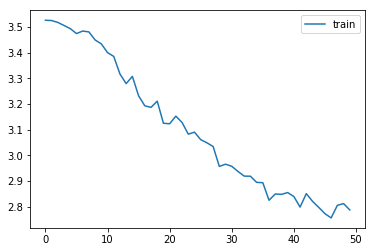

In [22]:
with sess.as_default():
    for i in tqdm_notebook(range(1000)):
        batch = generate_batch(graph, 20)
        
        training_step.run(feed_dict = {encoder_input : batch})
        if i %20 == 0:
            curr_loss = loss.eval(feed_dict = {encoder_input : batch})
            tqdm.tqdm.write(str(curr_loss))
            losses.append(curr_loss)

            display.clear_output(wait=True)
            plt.plot(losses, label='train')
        #    plt.plot(v_losses_valid, label='validation')
            plt.legend()
            plt.show()

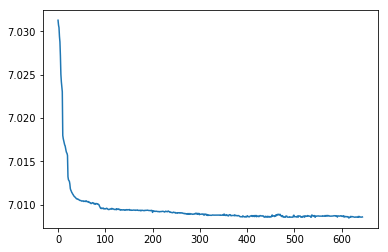

In [48]:
plt.plot(losses)
plt.show()

In [25]:
embeddings = encoder_embedding_layer.weights[0].eval(sess)

In [26]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [27]:
tsne = TSNE()

In [28]:
embeddings.shape

(34, 20)

In [43]:
emb_2 = tsne.fit_transform(embeddings[1:])

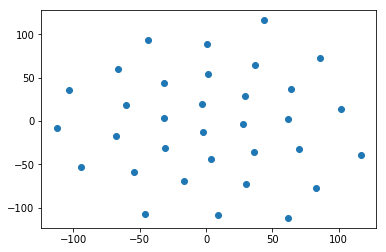

In [44]:
plt.scatter(emb_2[:,0], emb_2[:,1])
plt.show()

In [31]:
kmeans = KMeans(2)

In [42]:
kmeans.fit_predict(embeddings[1:])

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int32)

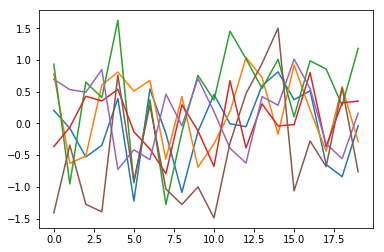

In [41]:
plt.plot(embeddings[1])
plt.plot(embeddings[2])
plt.plot(embeddings[3])
plt.plot(embeddings[4])
plt.plot(embeddings[5])
plt.plot(embeddings[6])
plt.show()

In [33]:
embeddings

array([[  4.35739420e-02,   2.87721269e-02,  -3.80296111e-02,
         -1.49513856e-02,   3.38901021e-02,   1.04888529e-03,
         -1.47827156e-02,   4.96635586e-03,   5.76703623e-03,
          7.58221000e-03,   1.74734257e-02,  -4.84716892e-03,
          4.07825746e-02,   4.14962806e-02,   4.92767952e-02,
         -2.51779705e-03,  -4.14041877e-02,  -4.96708527e-02,
          4.86723073e-02,  -1.27514377e-02],
       [  2.06128091e-01,  -7.62348697e-02,  -5.28735816e-01,
         -3.44946563e-01,   3.93964052e-01,  -1.22282362e+00,
          5.42111278e-01,  -1.59186587e-01,  -1.08684444e+00,
         -1.28034368e-01,   4.55373675e-01,  -5.03188977e-03,
         -5.19854650e-02,   5.94709754e-01,   8.13194215e-01,
          3.74286026e-01,   5.16288102e-01,  -6.47426188e-01,
         -8.40066254e-01,  -3.85955758e-02],
       [  7.84503758e-01,  -6.29568875e-01,  -5.14154673e-01,
          6.03017271e-01,   8.10066044e-01,   5.09189069e-01,
          6.77750051e-01,  -5.62126517e-01

In [35]:
encoder_embedding.eval(session=sess, feed_dict={encoder_input : np.ones(20).reshape(1,-1)})

array([[[ 0.073212  , -0.08893599,  0.42488515,  0.4325026 , -0.34184006,
          0.02520423, -0.49879622, -0.02479433, -0.49715319,  0.05073972,
         -0.19701755,  0.31196734, -0.26460022, -0.08007777, -0.33122519,
          0.17284574,  0.0723097 ,  0.07751129, -0.21280366, -0.26892194],
        [ 0.073212  , -0.08893599,  0.42488515,  0.4325026 , -0.34184006,
          0.02520423, -0.49879622, -0.02479433, -0.49715319,  0.05073972,
         -0.19701755,  0.31196734, -0.26460022, -0.08007777, -0.33122519,
          0.17284574,  0.0723097 ,  0.07751129, -0.21280366, -0.26892194],
        [ 0.073212  , -0.08893599,  0.42488515,  0.4325026 , -0.34184006,
          0.02520423, -0.49879622, -0.02479433, -0.49715319,  0.05073972,
         -0.19701755,  0.31196734, -0.26460022, -0.08007777, -0.33122519,
          0.17284574,  0.0723097 ,  0.07751129, -0.21280366, -0.26892194],
        [ 0.073212  , -0.08893599,  0.42488515,  0.4325026 , -0.34184006,
          0.02520423, -0.49879622, 

In [36]:
filepath_weights="weights-improvement.hdf5"
filepath_loss="loss-all-{epoch:02d}.hdf5"

In [37]:
weights_monitor = ModelCheckpoint(filepath_weights, monitor = 'loss', save_best_only=True, save_weights_only=True)
#loss_monitor = ModelCheckpoint(filepath_loss, monitor = 'loss', save_best_only=True, save_weights_only=True)

In [38]:
callbacks_list = [weights_monitor, loss_monitor]

In [18]:
encoder_out_1

<tf.Tensor 'time_distributed_8/Reshape_1:0' shape=(?, ?, 34) dtype=float32>

In [39]:
total_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [40]:
learning_progress = total_model.fit([X[:,:], X[:,:-1]], Y[:,1:,1:],
                                    batch_size=20,
                                    epochs=100,
                                    validation_split=0,callbacks = callbacks_list)

Epoch 1/100
1752/1752 [==============================] - 10s 6ms/step - loss: 1.4428
Epoch 2/100
1752/1752 [==============================] - 8s 5ms/step - loss: 1.3295
Epoch 3/100
1752/1752 [==============================] - 8s 4ms/step - loss: 1.3185
Epoch 4/100
1700/1752 [============================>.] - ETA: 0s - loss: 1.3132

KeyboardInterrupt: 